# Main Analysis

This file represents the main analysis done for this project. 

Originally, I downloaded all the relevant data using `sigcseArchive.py` and then spread this analysis over two separate python scripts (`process.py` and `process-2.py`). A handful of other scripts were used for one-off analysis (e.g., labeling emails types, tonal analysis with Watson, word frequency over time charts). These scripts were extremely tenuous and relied on some curious behavior within Spyder, so I decided to rewrite them before SIGCSE'19. A major modification to my process was to reorient the pipeline to more clearly consolidate all the data needed for analysis into one Sqlite database (previously, all the relevant data was spread out over a number of directories in the `data/` folder). Some details that reflect my original process may have been lost in this refactoring, but I felt that providing a more clear, transparent end-product is more valuable than preserving my original process.

# Imports

In [1]:
# Built-ins
import os
import sys
from datetime import date as datetime_date
from dateutil.parser import parse
import re
import math
from collections import Counter
import codecs
import json
from itertools import tee, islice, combinations
import sqlite3

# Common data libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import numpy as np
import scipy.stats as stats
import sklearn.metrics as metrics

# Handling unicode
from unidecode import unidecode

# Text analysis
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from wordcloud import WordCloud, STOPWORDS
from nltk import word_tokenize
from textstat.textstat import textstat
import editdistance

# Graph libraries
import networkx as nx

# Useful stuff I wrote/found
from helpers.stepwise import forward_selected
from helpers.states import state_names
from helpers.time import (strptime_with_offset, MONTH_MAP, NUM_MONTH, 
                          to_2digit_month, SHORT_MONTH_NAMES, HOUR_LIST,
                         DAYS_OF_WEEK)
from helpers.text import (strip_punctuation, stop, trans_table, 
                          clean_text, sentiment_extracter, normalize_name)
from helpers.plotting import plt_stagger_xticks, flatten_multiple_indexes

# Configurations


In [2]:
DATABASE_FILE = "data/sigcse-emails.db"
DEGREE_FILE = 'data/degrees.csv'
UNEMPLOYMENT_FILE = 'data/UNRATE.csv'
TOP_POSTERS_PRODUCTIVITY_FILE = 'data/top_posters.csv'
THREAD_FOLDER = "results/threads/"
ATTACHMENTS_FOLDER = "data/attachments/"

# Loading Sqlite Database


In [3]:
conn = sqlite3.connect(DATABASE_FILE)
emails = pd.read_sql_query("select * from email;", conn, index_col='id')
threads = pd.read_sql_query("select * from thread;", conn, index_col='id')

In [4]:
emails.sample(3)

,thread_id,sent,sender,subject,body,kind
id,,,,,,
2456_ind0501D,2005/1/4/14,2005-01-26 02:08:31,[log in to unmask],RFI : User Interface Programming,At short notice I have been asked to lecture a...,Normal
26265_ind1110D,2011/10/4/3,2011-10-27 03:40:47,Barry Brown,Re: Designing a CS classroom,(I know this is a bit of a digression from the...,Normal
33928_ind1002C,2010/2/3/22,2010-02-17 06:12:55,Michael Stein,Re: You are an Old Fogey if...,"L)\n\nThe presence of a ""one"" key on the typew...",Normal


In [5]:
threads.sample(3)

,year,month,week,ith
id,,,,
2013/1/5/5,2013,1,5,5
2010/2/2/11,2010,2,2,11
2014/11/3/15,2014,11,3,15


# Data Cleaning

We remove all punctuation from the sender, and also change the unlisted folks to a more visually appealing label.

In [6]:
emails.sender = emails.sender.apply(strip_punctuation)
emails.sender = emails.sender.replace('log in to unmasklog in to unmask', '<Unlisted>')
emails.sender = emails.sender.replace('log in to unmask', '<Unlisted>')

Sent dates are changed to datetime objects, and we have to correct a null value.

In [7]:
# Hack: This version of the dataset has a null time for one email
# Apparently, that date got entered as "Tue, 19 Jan 0100 12:33:38 -0500"
# Note the year :)
emails.at['5252_ind0001C', 'sent'] = "2000-01-19 12:33:38"
emails.sent = pd.to_datetime(emails.sent)

Email bodies have any edge whitespace trimmed.

In [8]:
emails.body = emails.body.str.strip()

We precalculate some descriptive statistics (e.g., lengths)

In [9]:
threads['quantity'] = emails.groupby(by='thread_id').sent.count().astype(int)
emails['length'] = emails.body.map(len).astype(int)

# Thread Statistics

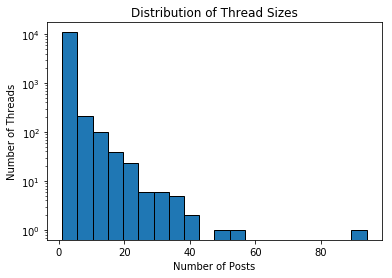

In [11]:
# What is the distribution of thread length?
# Most threads are short, but some threads are very long.
# Notice the logarithmic Y-axis.
threads.quantity.plot.hist(log=True, bins=20, histtype='bar', ec='black')
plt.ylabel("Number of Threads")
plt.xlabel("Number of Posts")
plt.title("Distribution of Thread Sizes")
plt.show()

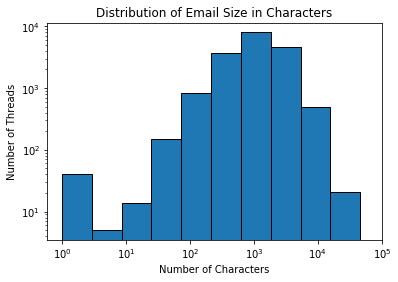

In [12]:
# How long are emails?
# Answer: Emails can range in size significantly.
# Many emails are very short, but some can be very long.
# There's a definite bimodal distribution, possibly related
# to the issue of blank emails.

email_lengths = emails.length.apply(lambda x: np.log10(x) if x > 0 else 0)
email_lengths.plot.hist(log=True,histtype='bar', ec='black')
plt.xticks(range(0, 6), ["10$^{}$".format(x) for x in range(0, 6)])
plt.ylabel("Number of Threads")
plt.xlabel("Number of Characters")
plt.title("Distribution of Email Size in Characters")
plt.show()

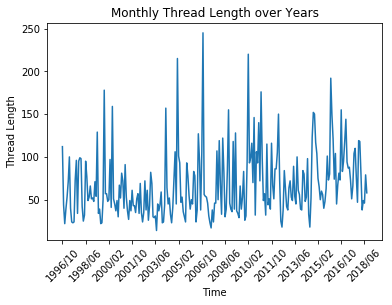

In [13]:
# Monthly Thread Length over Years

def ym(thread):
    return thread.year.astype(str)+"/"+thread.month.map(to_2digit_month)
year_month_groups = threads.assign(year_month=ym).groupby(by='year_month')
year_month_quantities = year_month_groups.quantity.sum()
year_month_quantities.plot()
plt_stagger_xticks(year_month_quantities.index)
plt.title("Monthly Thread Length over Years")
plt.xlabel("Time")
plt.ylabel("Thread Length")
plt.show()

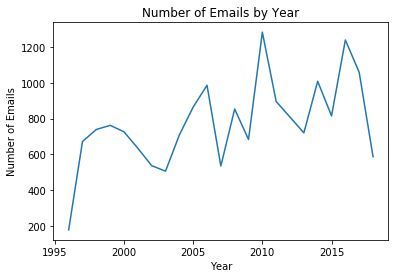

In [14]:
# Number of Emails by Year
threads.groupby(by='year').quantity.sum().plot()
plt.title("Number of Emails by Year")
plt.xlabel("Year")
plt.ylabel("Number of Emails")
plt.show()

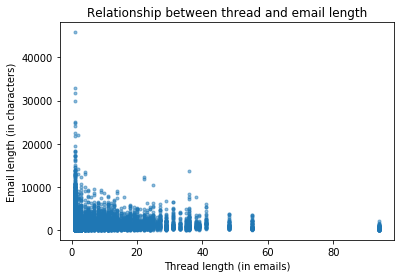

In [15]:
# Do longer threads have longer emails?
# Answer: Hm, possibly the inverse is true. This scatterplot
# seems to suggest that long threads have relatively short
# emails - longer emails are usually isolated to short threads.
# TODO: It appears about 700 emails have 0 length - individual inspection
#       suggests this may have been a download error. Investigate later.
emails_by_thread = emails.query('length > 0').join(threads, on='thread_id')
plt.scatter(emails_by_thread.quantity, emails_by_thread.length, 
            alpha=.5, marker='.')
plt.xlabel("Thread length (in emails)")
plt.ylabel("Email length (in characters)")
plt.title("Relationship between thread and email length")
plt.show()

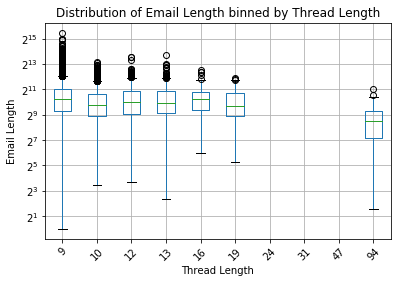

In [16]:
# What is the relationship between thread length and
# the distribution of email lengths?
# Answer: Follow-up analysis suggests there isn't one.
# The effect we saw before was more of a narrowing caused
# by the lack of data available at larger thread sizes.
BIN_COUNT = 10
# Compute integer labels instead of [START, STOP] pairs
labels = [int(round(emails_by_thread.quantity.max()/i))
          for i in reversed(range(1, 1+BIN_COUNT))]
binned_thread_length = pd.cut(emails_by_thread.quantity, BIN_COUNT,
                             labels=labels)
emails_by_thread.assign(bins=binned_thread_length).boxplot(column='length', by='bins')
plt.title("Distribution of Email Length binned by Thread Length")
plt.suptitle("")
plt.xlabel("Thread Length")
plt.ylabel("Email Length")
plt.yscale('log', basey=2)
plt.xticks(rotation=45)
# Harmless warning about invalid values - this is because some of the bins are empty, I believe.
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="invalid value encountered in less_equal")
    plt.show()

# Time Oriented Analysis

Various analytics over time

Linear Regression for Trend Line of Emails
	Slope: 0.12
	Correlation Coefficient: 0.24
	P-value (<.05?): 0.0001 (True)
	Standard Error: 0.03


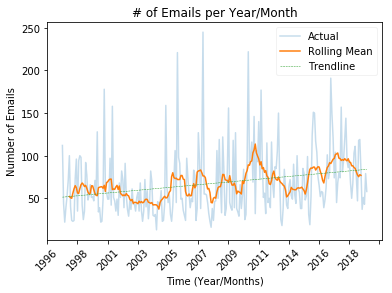

In [16]:
# What is the trend in emails over years? Has it increased or
# decreased?
# Answer: In general, we have seen growth (particularly the last few years)
# A regression line holds strong, but has a small slope.

# Actual plot of emails by year/month
emails_by_ym = emails.groupby([emails.sent.dt.year, emails.sent.dt.month]).kind.count()
emails_by_ym.index = emails_by_ym.index.rename(['Year', 'Month'])
actual_axes = emails_by_ym.plot(alpha=.25, label='Actual')

# 12-month rolling average
WINDOW_SIZE_IN_MONTHS = 12
rolling_average_by_ym = emails_by_ym.rolling(WINDOW_SIZE_IN_MONTHS, center=True).mean()
rolling_axes = rolling_average_by_ym.plot(title="Quantity of Posts over Time",
                                          label="Rolling Mean")

# 12-month expanding average
time_period = np.arange(0, len(emails_by_ym))
m, b, r, p, e = stats.linregress(time_period, emails_by_ym)
print("Linear Regression for Trend Line of Emails")
print("\tSlope:", round(m, 2))
print("\tCorrelation Coefficient:", round(r, 2))
print("\tP-value (<.05?):", round(p, 4), "({})".format(p<.05))
print("\tStandard Error:", round(e, 2))
plt.plot(time_period, time_period*m+b, '--', linewidth=.5,
        label="Trendline")

# Labels and Axes Cleanup
plt.xticks(rotation=45)
start, end = rolling_axes.get_xlim()
stepsize = 13*2
rolling_axes.xaxis.set_ticks(np.arange(start, end, stepsize))
tick_labels = rolling_average_by_ym.index[::stepsize].get_level_values('Year')
rolling_axes.set_xticklabels(tick_labels)

plt.legend(loc='best', framealpha=.25)
plt.ylabel("Number of Emails")
plt.xlabel("Time (Year/Months)")
plt.title("# of Emails per Year/Month")
plt.show()

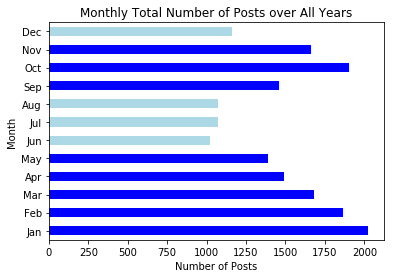

In [17]:
# How many emails have there been in a month over years? Are there
# seasonal or monthly variations?
# Answer: It varies a lot by month. Summer and December are much lower than
# other months, and there are peaks right around SIGCSE submission deadlines
# and during the conference.

monthly_emails = emails.groupby(emails.sent.dt.strftime('%b')).kind.count()
# Fix order
monthly_emails = monthly_emails.reindex(SHORT_MONTH_NAMES)
color_groups = (['blue']*5 + ['lightblue']*3 + ['blue']*3 + ['lightblue'])
monthly_emails.plot.barh(color=color_groups)
plt.xlabel("Number of Posts")
plt.ylabel("Month")
plt.title("Monthly Total Number of Posts over All Years")
plt.show()

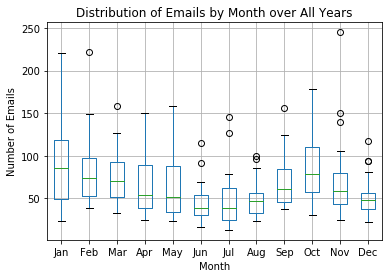

In [18]:
# How much variation is there within and across months over the years?
# Answer: A fair bit - the differences within months seems to be as
# much as the difference between months.

year_month = [emails.sent.dt.year, emails.sent.dt.strftime('%b')]
emails_by_my = emails.groupby(by=year_month).kind.count()
emails_by_my.index = emails_by_my.index.rename(['Year', 'Month'])
emails_by_my = emails_by_my.unstack()
emails_by_my = emails_by_my.reindex(SHORT_MONTH_NAMES, axis=1)
emails_by_my.boxplot()

plt.xlabel("Month")
plt.ylabel("Number of Emails")
plt.title("Distribution of Emails by Month over All Years")

plt.show()

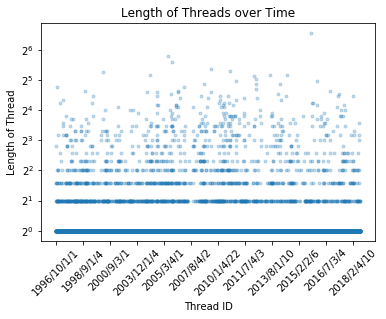

In [19]:
## What is the distribution of thread length over time?
# Answer: The scatter plot below visualizes the range
# of thread lengths over the entire time range. Note
# the Y axis is logarithmic, suggesting how large
# some of the threads can get. Overall, few threads
# get very large, but they can get pretty big when they do.
# There's a fairly consistent trend of small threads.
# Each square represents a single thread.
counts = emails.groupby('thread_id').kind.count()
counts.plot(marker='.', linestyle='', alpha=.25)
plt_stagger_xticks(counts.index, 1000)
plt.yscale('log', basey=2)
plt.xlabel("Thread ID")
plt.ylabel("Length of Thread")
plt.title("Length of Threads over Time")
plt.show()

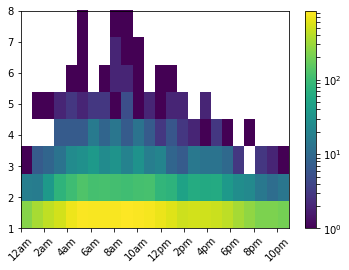

In [20]:
# What is the distribution of emails over the course of a single day?
# Answer: Emails can happen throughout the day, but more emails
# are more likely during US business hours, particularly the morning.
hour_day = [emails.sent.dt.hour, 
              emails.sent.dt.strftime('%d/%m/%Y')]
emails_by_hd = emails.groupby(by=hour_day).sent.count()
emails_by_hd.index = emails_by_hd.index.rename(['Hour', 'Date'])
plt_stagger_xticks(HOUR_LIST, 2)
flattened_emails_by_hd = emails_by_hd.reset_index()
MAX_EMAILS_SENT = flattened_emails_by_hd.sent.max()
plt.hist2d(flattened_emails_by_hd["Hour"], flattened_emails_by_hd["sent"],
           norm=matplotlib.colors.LogNorm(), 
           bins=[len(HOUR_LIST), MAX_EMAILS_SENT])
plt.colorbar()
plt.show()

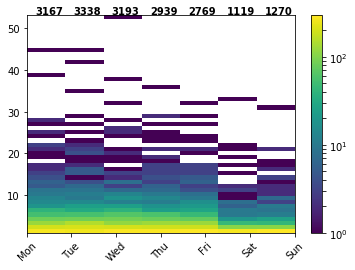

In [21]:
# What is the distribution of emails over the course of a single week?
# Answer: Emails can happen throughout the week, but more emails
# are more likely during weekdays, particularly earlier in the week.
dow_day = [emails.sent.dt.dayofweek, 
           emails.sent.dt.strftime('%d/%m/%Y')]
emails_by_dd = emails.groupby(by=dow_day).sent.count()
emails_by_dd.index = emails_by_dd.index.rename(['Day of Week', 'Date'])
plt_stagger_xticks(DAYS_OF_WEEK, 1)
flattened_emails_by_dd = emails_by_dd.reset_index()
MAX_EMAILS_SENT = flattened_emails_by_dd.sent.max()
_, xbins, _, _ = plt.hist2d(flattened_emails_by_dd["Day of Week"], 
                            flattened_emails_by_dd["sent"],
                            norm=matplotlib.colors.LogNorm(), 
                            bins=[len(DAYS_OF_WEEK), MAX_EMAILS_SENT])
plt.colorbar()
# Annotate the columns with the subtotals
dow_totals = emails_by_dd.groupby('Day of Week').sum()
for dow, xbin in enumerate(xbins[:len(dow_totals)]):
    plt.text(xbin+0.5, MAX_EMAILS_SENT+1, 
             dow_totals[dow], 
             color="black", ha="center", 
             va="center", fontweight="bold")
plt.show()

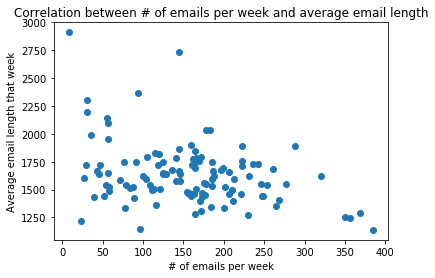

In [22]:
# Is there a relationship between the number of posts each week
# and the average length of the emails?
# Answer: No, not really.
weekly_emails = emails.join(threads, on='thread_id').groupby(['year', 'week'])
weekly_email_count = weekly_emails.kind.count()
weekly_email_length = weekly_emails.length.mean()
plt.scatter(weekly_email_count, weekly_email_length)
plt.title("Correlation between # of emails per week and average email length")
plt.xlabel("# of emails per week")
plt.ylabel("Average email length that week")
plt.show()

# Thread Duration

In [23]:
# Basically, find adjacent time differences between emails
# and then sum them up within thread groups.
email_durations = emails.sort_values(['thread_id', 'sent'], ascending=True).groupby(by='thread_id').sent.diff().fillna(0)
thread_durations = emails.assign(durations=email_durations).groupby('thread_id').durations.sum()
thread_durations = thread_durations[thread_durations > pd.Timedelta(0)]
# Adds an extra second for... some reason - I'm not entirely sure why!
thread_durations_decimal = ((pd.to_timedelta(thread_durations,unit='d')+
                             pd.to_timedelta(1,unit='s')) / np.timedelta64(1,'D'))

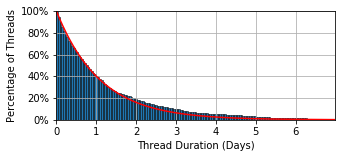

MSE: 0.0338094251032


In [24]:
# How long do non-trivial threads (having more than one post) last?
# Answer: Thread duration follows an inverse expontial curve very closely.
# Basically, every day the likelihood of another response is halved.
# It's actually a 1/2.5^x decay, but that's pretty close to halving.
progress = thread_durations_decimal[thread_durations_decimal< 30]

WIDTH = 7
BINS = (1+int(progress.max()))*24

axs = progress.hist(bins=BINS, cumulative=-1, normed=True,
                    histtype='bar', ec='black', lw=.5)
heights = [p._height for p in axs.patches]

plt.xticks(range(0, WIDTH, 1))
plt.xlim(0, WIDTH)
plt.ylim(0, 1)
plt.xlabel("Thread Duration (Days)")
plt.ylabel("Percentage of Threads")
xs = np.arange(0, WIDTH, WIDTH/BINS)
ys = [1/(2.5**x) for x in xs]
#per_formatter = FuncFormatter(lambda x: x+"%")
#plt.gca().yaxis.set_major_formatter(per_formatter)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.gcf().set_size_inches((5, 2))
plt.plot(xs, ys, color='r', label="Predicted")
plt.show()
print("MSE:", metrics.mean_squared_error(pd.Series(heights), pd.Series(ys)))

# Degree and Jobs Data

As a proxy for "popularity of CS", we will use the number of degrees granted.

In order to get the degree granted data up to date to 2016, I had to extract the data from a graph I found online. Inspection of the computed results compared to known values indicated that it was very approximately correct - sufficient for my ad-hoc purposes.

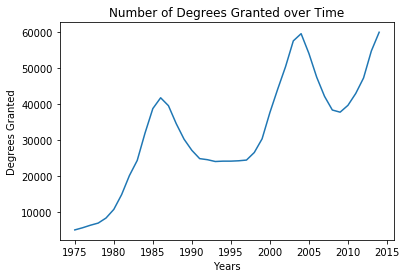

In [25]:
degrees = pd.read_csv(DEGREE_FILE)
degrees['Year'] = degrees['Year'].apply(round)
degrees['Degrees'] = degrees['Degrees'].apply(lambda x: round(x/100)*100)
degrees = degrees.set_index('Year')
plt.plot(degrees['Degrees'])
plt.title("Number of Degrees Granted over Time")
plt.xlabel("Years")
plt.ylabel("Degrees Granted")
plt.show()

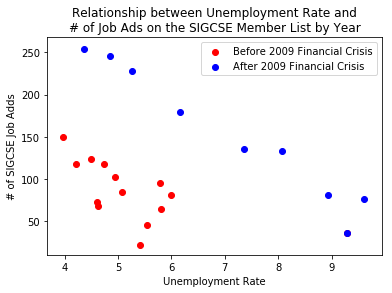

In [26]:
# What is the relationship between Job postings on the members mailing list
# and National Unemployment?
# Answer: It's a fairly strong relationship - the higher the unemployment, the
# fewer job ads we see. There's an interesting bifurcation before and after
# the 2009 financial crisis, but that doesn't really affect the tend itself.

# Job Posts
jobs_before_2017 = emails[(emails.kind=="Job") & (emails.sent.dt.year <= 2017)]
jobs_before_2017 = jobs_before_2017.groupby(jobs_before_2017.sent.dt.year).kind.count()
jobs_before_2017.index = jobs_before_2017.index.map(int)

# Unemployment Rate
unemployment_rate = pd.read_csv(UNEMPLOYMENT_FILE)
DATE_COLUMNS = ['Month', 'Day', 'Year']
unemployment_rate[DATE_COLUMNS] = unemployment_rate['DATE'].str.split('/', expand=True)
unemployment_rate[DATE_COLUMNS] = unemployment_rate[DATE_COLUMNS].astype(int)
unemployment_rate = unemployment_rate.query('1995 < Year < 2018')
unemployment_rate_by_year = unemployment_rate.groupby(by='Year').mean()['UNRATE']

# Observation: There is a bifurcation in the after the 2009 financial crisis
# Makes sense to color the two trends to highlight this weird temporal event.
CRISIS = 2009
plt.scatter(unemployment_rate_by_year.loc[:CRISIS], jobs_before_2017.loc[:CRISIS],
            color='red', label='Before 2009 Financial Crisis')
plt.scatter(unemployment_rate_by_year.loc[CRISIS:], jobs_before_2017.loc[CRISIS:],
            color='blue', label='After 2009 Financial Crisis')

plt.xlabel("Unemployment Rate")
plt.ylabel("# of SIGCSE Job Adds")
plt.title("Relationship between Unemployment Rate and\n# of Job Ads on the SIGCSE Member List by Year")
plt.legend()
plt.show()

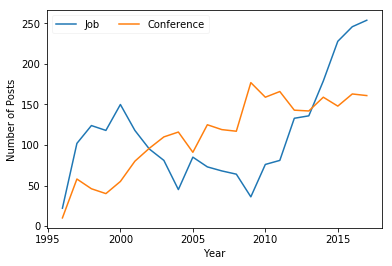

In [27]:
# What is the trend in Jobs and Conference postings over the years?
# Answer: Looks like the rates have not been the same.
# Jobs took a hit during the recession, but conferences
# have been more or less increasing over the years.
emails_by_kind = emails.groupby(by=emails.sent.dt.year).kind.value_counts().unstack()
# 2018 is missing a few months, let's not let it get cut off
emails_by_kind = emails_by_kind.query('sent < 2018')
emails_by_kind['Job'].plot(label='Job')
emails_by_kind['Conference'].plot(label='Conference')
plt.legend(loc='best', framealpha=0.2, ncol=2)
plt.xlabel("Year")
plt.ylabel("Number of Posts")
plt.show()

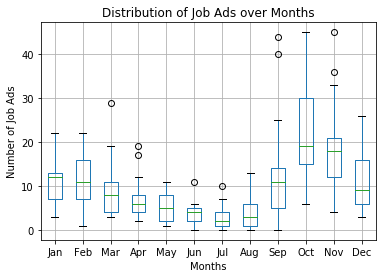

In [28]:
# How many job ads are there per month?
# It varies a lot over the course of the year. Job ads seem
# to peak in October.
year_month = [emails.sent.dt.year, emails.sent.dt.month]
job_emails = emails.query('kind == "Job" and sent.dt.year > 1996 and sent.dt.year < 2018')
job_emails_by_ym = job_emails.groupby(by=year_month).kind.count()
job_emails_by_ym.index = job_emails_by_ym.index.rename(['Year', 'Month'])
job_emails_table = job_emails_by_ym.unstack('Month').fillna(0)
job_emails_table.columns = SHORT_MONTH_NAMES
job_emails_table.boxplot()
plt.title("Distribution of Job Ads over Months")
plt.xlabel("Months")
plt.ylabel("Number of Job Ads")
plt.show()

# Textual Analysis


Now let's take a look at the actual content of the emails from a quantitative perspective

In [29]:
# Polarity calculation takes a long time. Several whole seconds.
pattern_polarities = emails.body.apply(sentiment_extracter(False))
pattern_polarities = pattern_polarities.rename("Polarity")

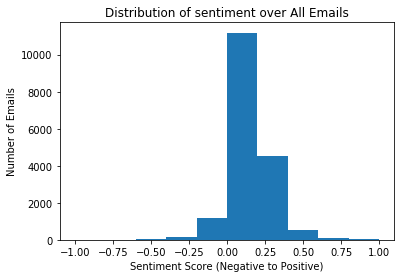

In [30]:
# What is the sentiment across messages?
# Answer: most emails tend to be neutral to mid-positive.
# Manual review of the negative emails suggest that they
# are largely polite apologies ("I'm sorry!").
pattern_polarities.plot.hist()
plt.title("Distribution of sentiment over All Emails")
plt.xlabel("Sentiment Score (Negative to Positive)")
plt.ylabel("Number of Emails")
plt.show()

Linear Regression for Trend Line of Emails
	Slope: 0.0
	Correlation Coefficient: 0.11
	P-value (<.05?): 0.0 (True)
	Standard Error: 0.0


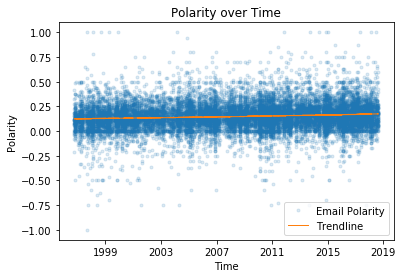

In [31]:
# What is the change in polarity over time?
# There is no particular change in polarity over time.
# A linear regression line indicates a slope of almost 0.
emails_with_polarity = emails.join(pattern_polarities)
plt.plot(emails_with_polarity.sent, emails_with_polarity.Polarity,
         linestyle='', marker='.', alpha=.15,
        label="Email Polarity")

time_period = np.arange(0, len(emails_with_polarity))
m, b, r, p, e = stats.linregress(time_period, emails_with_polarity.Polarity)
print("Linear Regression for Trend Line of Emails")
print("\tSlope:", round(m, 2))
print("\tCorrelation Coefficient:", round(r, 2))
print("\tP-value (<.05?):", round(p, 4), "({})".format(p<.05))
print("\tStandard Error:", round(e, 2))
plt.plot(emails_with_polarity.sent.iloc[time_period],
         time_period*m+b, '-', linewidth=1,
        label="Trendline")

plt.title("Polarity over Time")
plt.ylabel("Polarity")
plt.xlabel("Time")
plt.legend()
plt.show()

In [32]:
# Did not run bayesian polarity, took too long on my machine.
# Potentially interesting future work though?
#e = emails.body.apply(sentiment_extracter(True))

# User Analysis

In [33]:
# Original analysis used normalize_name
#emails.sender.apply(normalize_name)
# This only accounted for 350 names, and in some cases
# may have merged unconnected folks.
# So I'm ditching it for now.
# str.lower() only accounts for another 35 names
# str.strip() accounts for an additional 9

sender_counts = emails.sender.value_counts()
top_posters = sender_counts[sender_counts > 20]

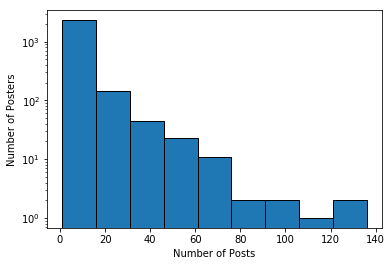

In [34]:
# How many posts do each posters make?
# Answer: There's an exponential relationship - the most posters
# make many posts, but most posters make only a few.
posts_by_poster = emails.groupby('sender').sender.count().drop('<Unlisted>')
posts_by_poster.plot.hist(bins=np.arange(1, 150, 15), log=True, 
                         histtype='bar', ec='black')
plt.xlabel('Number of Posts')
plt.ylabel("Number of Posters")
plt.show()

In [35]:
# of posts
print("Number of posts:", len(emails))
# of unique posters
print("Number of users:", len(emails.sent.unique()))
# Quiets
quiet_people = posts_by_poster[(posts_by_poster<=2)].index
quiets = emails[emails.sender.isin(quiet_people)].sender
print("Number of quiets", len(quiets.unique()))
print("Number of quiets posts", len(quiets))
print("Quiets as % of users", round(100*len(quiets.unique())/len(emails.sender.unique()), 2))
print("Quiets' % of posts:", round(100*len(quiets)/len(emails), 2))
# Regulars
regular_people = posts_by_poster[(posts_by_poster>2) & (posts_by_poster<=20)].index
regulars = emails[emails.sender.isin(regular_people)].sender
print("Number of regulars", len(regulars.unique()))
print("Number of regulars posts", len(regulars))
print("Regulars as % of users", round(100*len(regulars.unique())/len(emails.sender.unique()), 2))
print("Regulars' % of posts:", round(100*len(regulars)/len(emails), 2))
# Actives
active_people = posts_by_poster[(posts_by_poster>20) & (posts_by_poster<=50)].index
actives = emails[emails.sender.isin(active_people)].sender
print("Number of actives", len(actives.unique()))
print("Number of active posts", len(actives))
print("Actives as % of users", round(100*len(actives.unique())/len(emails.sender.unique()), 2))
print("Actives' % of posts:", round(100*len(actives)/len(emails), 2))
# Super
superactive_people = posts_by_poster[posts_by_poster>50].index
superactives = emails[emails.sender.isin(superactive_people)].sender
print("Number of supers", len(superactives.unique()))
print("Number of super posts", len(superactives))
print("Supers as % of users", round(100*len(superactives.unique())/len(emails.sender.unique()), 2))
print("Supers' % of posts:", round(100*len(superactives)/len(emails), 2))

Number of posts: 17795
Number of users: 17791
Number of quiets 1394
Number of quiets posts 1783
Quiets as % of users 54.82
Quiets' % of posts: 10.02
Number of regulars 986
Number of regulars posts 6953
Regulars as % of users 38.77
Regulars' % of posts: 39.07
Number of actives 127
Number of active posts 3894
Actives as % of users 4.99
Actives' % of posts: 21.88
Number of supers 35
Number of super posts 3233
Supers as % of users 1.38
Supers' % of posts: 18.17


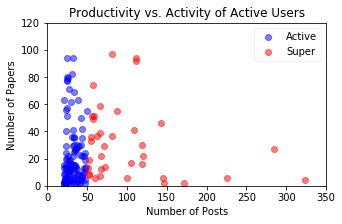

In [36]:
# Are active and superactive posters more likely to have published at SIGCSE?
# Answer: Surprisingly, not really. The graph shows no real relationship.
activity_productivity = pd.read_csv(TOP_POSTERS_PRODUCTIVITY_FILE)
activity_productivity = activity_productivity[activity_productivity['Papers'] > 0]
active = activity_productivity[activity_productivity['Posts'] <= 50]
supers = activity_productivity[activity_productivity['Posts'] > 50]
plt.scatter(active['Posts'], active['Papers'],
            alpha=.5, color='b', label='Active')
plt.scatter(supers['Posts'], supers['Papers'],
            alpha=.5, color='r', label='Super')
plt.ylim(0, 120)
plt.xlim(0, 350)
plt.legend(loc='best', framealpha=.25)
plt.gcf().set_size_inches((5, 3))
plt.xlabel("Number of Posts")
plt.ylabel("Number of Papers")
plt.title("Productivity vs. Activity of Active Users")
plt.show()

# Post Prediction

In [ ]:
emails.groupby()

In [ ]:
import importlib
import helpers.text
importlib.reload(helpers.text)

# Thread Text

Retrieve the longest threads (length>=20) and store them in separate HTML files.

In [10]:

# Email Metadata
collected = []
for email_metadata in os.listdir('data/parsed_emails/'):
    with open('data/parsed_emails/'+email_metadata) as email_metadata_file:
        row = json.load(email_metadata_file)
        row['id'] = email_metadata[:-5]
        collected.append(row)
e = {c['id']: c for c in collected}
# Attachments
attachments = {}
for attachment in os.listdir('data/attachments/'):
    with codecs.open('data/attachments/'+attachment, encoding='ISO-8859-1') as attachment_data:
        attachments[attachment] = attachment_data.read()

In [11]:
def clean_name(filename):
    return "".join([c for c in filename
                    if c.isalpha() or c.isdigit() 
                       or c in (' ', '.')]).rstrip()

def find_filename(path):
    for extension in ['.html', '.txt']:
        if os.path.exists(path+extension):
            return path+extension
    return None

with open(THREAD_FOLDER+"_template.html") as template_file:
    template_html = template_file.read()

from io import StringIO

'''<h2>{{ row['subject'].title() }}</h2>
                <sup>{{ row['sent'][:10] }}</sup>
                <pre>{{ row['body'] }}</pre>'''
d = emails.join(threads, on='thread_id')
final_files = []
for tid, g in d[d.quantity >= 20].groupby('thread_id'):
    subject = g.subject.iloc[0]
    when = g.sent.iloc[0]
    with StringIO() as out:
        print("<h1>", subject, "</h1>", file=out)
        print("<div><a target=_blank href='https://listserv.acm.org/SCRIPTS/WA-ACMLPX.CGI?A1={}&L=SIGCSE-MEMBERS'><button>Context</button></div>".format(
            g.index[0].split("_")[-1]
        ), file=out)
        
        flip = False
        for email in g.sort_values(by='sent').itertuples():
            flip = not flip
            print('<div class="container {}">'.format('right' if flip else 'left'), file=out)
            print('<div class="content">', file=out)
            e_data = e[email.Index]
            print("<sup>", file=out)
            print("<strong>", email.subject, "</strong>", "<br>", file=out)
            sent = email.sent.strftime('%A %B %d, %Y at %H:%M')
            print("By ", email.sender, "on", sent, "<br>", file=out)
            print("</sup>", file=out)
            text_files = [a for a in e_data['attachments'] if a.endswith('.txt')]
            if not any(text_files):
                html_files = [a for a in e_data['attachments'] if a.endswith('.html')]
                if not any(html_files):
                    attachment = e_data['attachments'][0]
                else:
                    attachment = html_files[0]
            else:
                attachment = text_files[0]
            body = attachments[attachment]
            is_txt = attachment.endswith('txt')
            url = attachment
            if False:
                with open("data/attachments/"+attachment, 'r', encoding='latin1') as inp:
                    with open(THREAD_FOLDER+attachment, 'w', encoding='latin1') as copied_file:
                        copied_file.write(inp.read())
            print("<a class='on-right' href=", repr(url),">{}</a>".format(attachment), file=out)
            print("<pre>" if is_txt else "<div>", file=out)
            print(body, file=out)
            print("</pre>" if is_txt else "</div>", file=out)
            print("</div>", file=out)
            print("</div>", file=out)
        html = out.getvalue()
    with open(THREAD_FOLDER+clean_name(subject)+".html", 'w', encoding='ISO-8859-1') as out:
        print(template_html.format(title=subject, html=html), file=out)
    final_files.append((when, subject, clean_name(subject)+".html"))
with open(THREAD_FOLDER+"index.html", 'w') as out:
    print("<h1>Threads</h1>", file=out)
    print("<style>button { padding: 10px; margin: 10px }</style>", file=out)
    print("<ul>", file=out)
    for when, subject, path in sorted(final_files):
        print("<li>{when} - <a target=_blank href='{path}'><button>{subject}</button></a></li>".format(
            path=path, subject=subject,
            when = when.strftime('%Y - %B %d')
        ), file=out)
    print("</ul>", file=out)

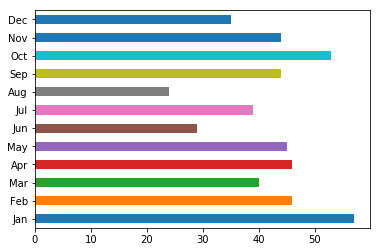

In [65]:
d = emails.join(threads, on='thread_id')
d[d.quantity >= 5].groupby('thread_id').head(1).sent.dt.strftime('%b').value_counts().reindex(SHORT_MONTH_NAMES).plot.barh()

In [1]:
#d = emails.join(threads, on='thread_id')
#d[d.quantity >= 5].groupby('thread_id')
threads[threads.quantity >= 35].count()

NameError: name 'threads' is not defined